# Predict `Subject Age`

In [ ]:
%matplotlib inline

In [ ]:
##### Step 1: import functions #####
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input, Softmax
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.random import set_seed; set_seed(111)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
from six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from IPython.display import Image  
import pydotplus
import time
from pathlib import Path

In [ ]:
# %config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = [9,6]

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
phenotype = 'Subject Age'

In [ ]:
#load data
aging_dir = Path('/home/ubuntu/a/aging')

with open(aging_dir/'aging-cytof-data.obj', 'rb') as f:
    allData = pickle.load(f)
samples = allData["samples"]
cyto_data = allData['expr_list']
# Truncate cytodata
cyto_data = cyto_data[ :, :int(5e3)]
markers = allData["marker_names"]

print(f'Dimensions of cyto_data: {cyto_data.shape}')
print(f'Dimensions of samples: {samples.shape}')
print(f'Names of the makers: {markers.values}')

Dimensions of cyto_data: (260, 5000, 27, 1)
Dimensions of samples: (260, 85)
Names of the makers: ['CELL_LENGTH' 'DEAD' 'CD19' 'CD4' 'CD8' 'IGD' 'CD85J' 'CD16' 'CD3' 'CD38'
 'CD27' 'CD14' 'CD94' 'CCR7' 'CD45RA' 'CD20' 'CD127' 'CD33' 'CD28' 'CD24'
 'CD161' 'TCRGD' 'CD56' 'HLADR' 'CD25' 'DNA1' 'DNA2']


count    260.000000
mean      68.303846
std       15.169696
min       41.000000
25%       55.000000
50%       69.000000
75%       82.000000
max       90.000000
Name: Subject Age, dtype: float64


<AxesSubplot:ylabel='Frequency'>

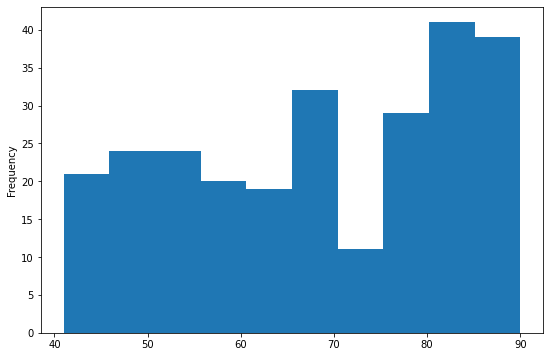

In [ ]:
print(samples[phenotype].describe())
samples[phenotype].plot.hist()

In [ ]:
a = cyto_data
a.shape

(260, 5000, 27, 1)

In [ ]:
a.min(2).shape

(260, 5000, 1)

In [ ]:
a.min(2)[0][0]

array([-0.18031569])

In [ ]:
c = a[0,:,0]
print(c.shape)
c

(5000, 1)


array([[2.35092572],
       [2.69916161],
       [2.09471255],
       ...,
       [2.09471255],
       [2.18742176],
       [2.35092572]])

In [ ]:
cm = c.min(0)
cm

array([1.44363548])

In [ ]:
c-cm

array([[0.90729024],
       [1.25552613],
       [0.65107707],
       ...,
       [0.65107707],
       [0.74378629],
       [0.90729024]])

In [ ]:
a.min(1)[0][0]

array([1.44363548])

In [ ]:
a-a.min(1)

ValueError: operands could not be broadcast together with shapes (260,5000,27,1) (260,27,1) 

In [ ]:
b=a[0]
b.shape

(5000, 27, 1)

In [ ]:
b.min(0)[0]

array([1.44363548])

In [ ]:
b

array([[[ 2.35092572],
        [-0.10675904],
        [-0.17587138],
        ...,
        [-0.05599354],
        [ 4.39221377],
        [ 5.15072445]],

       [[ 2.69916161],
        [-0.10019732],
        [-0.19617459],
        ...,
        [-0.18278234],
        [ 3.81487871],
        [ 4.37430716]],

       [[ 2.09471255],
        [-0.18636861],
        [-0.14411605],
        ...,
        [-0.12561546],
        [ 4.17630258],
        [ 5.26233433]],

       ...,

       [[ 2.09471255],
        [-0.16359327],
        [-0.07867508],
        ...,
        [-0.04051353],
        [ 4.40301115],
        [ 4.89954781]],

       [[ 2.18742176],
        [ 4.24421675],
        [-0.13060638],
        ...,
        [-0.04906191],
        [ 5.08445263],
        [ 5.54177817]],

       [[ 2.35092572],
        [ 1.48376719],
        [-0.08848496],
        ...,
        [-0.13364054],
        [ 3.89215252],
        [ 5.12389994]]])

In [ ]:
(b-b.min(0))/b.ptp(0)

array([[[4.63217235e-01],
        [1.22251421e-02],
        [6.80668810e-03],
        ...,
        [2.57460677e-02],
        [6.28204424e-01],
        [6.87687111e-01]],

       [[6.41009144e-01],
        [1.30991375e-02],
        [7.37239539e-04],
        ...,
        [2.86252265e-03],
        [5.49070641e-01],
        [5.87846368e-01]],

       [[3.32407543e-01],
        [1.62146756e-03],
        [1.62996387e-02],
        ...,
        [1.31803190e-02],
        [5.98610050e-01],
        [7.02039203e-01]],

       ...,

       [[3.32407543e-01],
        [4.65505085e-03],
        [3.58625834e-02],
        ...,
        [2.85399864e-02],
        [6.29684393e-01],
        [6.55387904e-01]],

       [[3.79740253e-01],
        [5.91757634e-01],
        [2.03382236e-02],
        ...,
        [2.69971261e-02],
        [7.23087765e-01],
        [7.37973334e-01]],

       [[4.63217235e-01],
        [2.24076845e-01],
        [3.29300150e-02],
        ...,
        [1.17319065e-02],
        [5.5966

In [ ]:
np.array(list(map(lambda x: (x-x.min(0))/x.ptp(0), cyto_data)))[0][0][0][0]

0.46321723540368925

In [ ]:
a1 = a[0].reshape(5000,27)
a1.shape

(5000, 27)

In [ ]:
a1c1min = a1.min(0)[0]
a1c1ptp = a1.ptp(0)[0]
print(a1c1min, a1c1ptp)

1.4436354751788103 1.9586711703017843


In [ ]:
(a[0][0][0][0] - a1c1min)/a1c1ptp

0.46321723540368925

In [ ]:
##### Step 3: split train, validation and test######
x = []
y = []
for i, row in samples.iterrows():
    x.append(cyto_data[i])
    y.append(row[phenotype])
age_range = max(y) - min(y)
x = np.asarray(x)
y_raw = np.asarray(y)
age_min = min(y_raw)
age_max = max(y_raw)
age_range = age_max - age_min
y = (y_raw - age_min) / age_range

x_train, x_valid, y_train, y_valid = train_test_split(x, y)

(195, 5000, 27, 1) (65, 5000, 27, 1)


In [ ]:
model = Sequential([
    Input(shape=x[0].shape),
    Conv2D(3, kernel_size = (1, x.shape[2]), activation=None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(6, kernel_size = (1,1), activation=None),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size = (x.shape[1], 1)),
    Flatten(),
    Dense(3, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dense(1, activation=None),
])
model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5000, 1, 3)        84        
_________________________________________________________________
batch_normalization (BatchNo (None, 5000, 1, 3)        12        
_________________________________________________________________
activation (Activation)      (None, 5000, 1, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5000, 1, 6)        24        
_________________________________________________________________
batch_normalization_1 (Batch (None, 5000, 1, 6)        24        
_________________________________________________________________
activation_1 (Activation)    (None, 5000, 1, 6)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 6)           0

In [ ]:
%%time
model_store = Path(f'Result/saved_weights_{phenotype}.hdf5')

# save the best performing model
checkpointer = ModelCheckpoint(filepath=model_store, 
                               monitor='val_loss', verbose=0, 
                               save_best_only=True)

st = time.time()
# model training
model.fit([x_train], y_train,
          batch_size=60,
          epochs=200, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([x_valid], y_valid))
rt = time.time()-st

Epoch 1/200
4/4 [==============================] - 5s 152ms/step - loss: 0.9608 - mean_absolute_error: 0.9608 - val_loss: 0.8493 - val_mean_absolute_error: 0.8493
Epoch 2/200
4/4 [==============================] - 0s 27ms/step - loss: 0.9456 - mean_absolute_error: 0.9456 - val_loss: 0.8496 - val_mean_absolute_error: 0.8496
Epoch 3/200
4/4 [==============================] - 0s 26ms/step - loss: 0.9403 - mean_absolute_error: 0.9403 - val_loss: 0.8498 - val_mean_absolute_error: 0.8498
Epoch 4/200
4/4 [==============================] - 0s 25ms/step - loss: 0.9109 - mean_absolute_error: 0.9109 - val_loss: 0.8499 - val_mean_absolute_error: 0.8499
Epoch 5/200
4/4 [==============================] - 0s 25ms/step - loss: 0.8851 - mean_absolute_error: 0.8851 - val_loss: 0.8499 - val_mean_absolute_error: 0.8499
Epoch 6/200
4/4 [==============================] - 0s 25ms/step - loss: 0.8971 - mean_absolute_error: 0.8971 - val_loss: 0.8500 - val_mean_absolute_error: 0.8500
Epoch 7/200
4/4 [==========

In [ ]:
rt

25.657243251800537

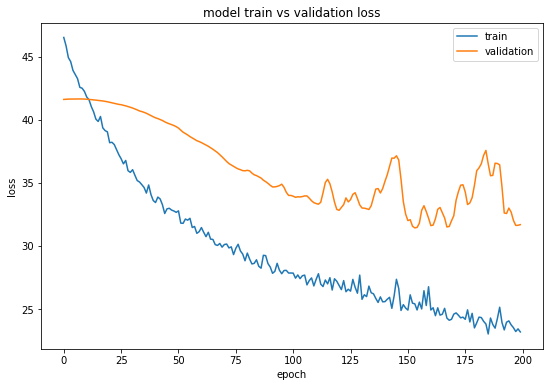

In [ ]:
##### Step 6: plot train and validation loss #####
history = model.history
plt.plot(age_range*pd.Series(history.history['mean_absolute_error']))
plt.plot(age_range*pd.Series(history.history['val_mean_absolute_error']))
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
#### Step 7: test the final model #####
final_model = load_model(model_store)
x_test = x_valid
y_test = y_valid
y_scores = final_model.predict([x_test])
y_scores = y_scores.reshape(y_scores.shape[0])

count    65.000000
mean      2.250081
std      12.456877
min     -18.937424
25%      -6.271919
50%       0.404343
75%      10.898132
max      38.640190
dtype: float64

In [ ]:
errors = age_range * (pd.Series(y_test)-pd.Series(y_scores))
errors.describe()

count    65.000000
mean     -0.833844
std      12.727778
min     -30.716756
25%     -10.602103
50%      -1.498725
75%       6.566408
max      29.643600
dtype: float64

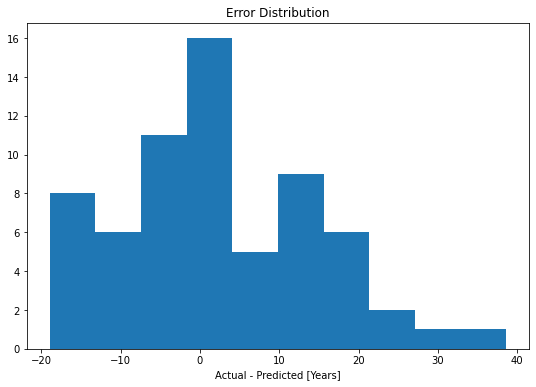

In [ ]:
plt.hist(errors)
plt.title('Error Distribution')
plt.xlabel('Actual - Predicted [Years]')
plt.show()

[ 0.32713579 48.34645497]


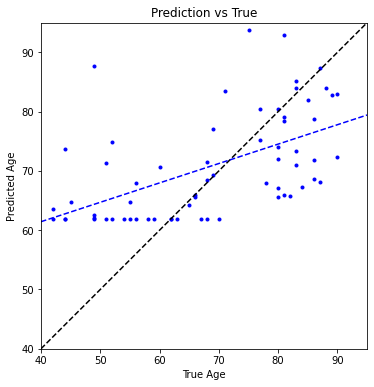

In [ ]:
age_true = y_test*age_range + age_min
age_pred = y_scores*age_range + age_min
plt.plot(age_true, age_pred,'b.')
plt.axis('square')
plt.xlim((40,95))
plt.ylim((40,95))
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Prediction vs True')
plt.plot([40,95],[40,95],'--k')
coef = np.polyfit(age_true, age_pred, 1)
print(coef)
poly1d_fn = np.poly1d(coef)
plt.plot([40,95], poly1d_fn([40,95]), '--b')
plt.show()